In [8]:
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784')

In [1]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

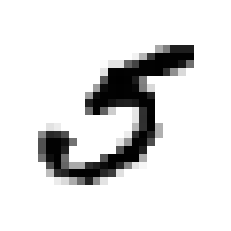

In [7]:
plt.imshow(some_digit_image, cmap= matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[36000]

5.0

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [10]:
import numpy as np

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [17]:
skfolds = StratifiedKFold(n_splits=3, random_state=42,  shuffle=True)

In [18]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))
    

0.9675
0.91485
0.96065


In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.967  , 0.96935, 0.96835])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9102 , 0.90925, 0.9095 ])

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[54097,   482],
       [ 1424,  3997]])

In [24]:
#confusion matrix 
#TN FP
#FN TP
#53647(TN) 932(FP)
#1296(FN) 4125(TP)
#precision = TP/(TP + FP)  or 4125/(4125+932)
#recall = TP/(TP + FN) or 4125/(4125+1296)

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8923866934583612

In [26]:
recall_score(y_train_5, y_train_pred)

0.7373178380372625

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8074747474747473

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([762.73154536])

In [29]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold=200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3,
                            method = "decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

In [35]:
print(y_train_5.shape)

(60000,)


In [38]:
print(y_scores.shape)

(60000,)


In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [44]:
def plot_presicion_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    

In [92]:
def plot_presicion_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    #plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("recalls")
    plt.ylabel("precisions")
    #plt.legend(loc="center left")
    plt.ylim([0,1])


In [48]:
print(precisions.shape)

(59842,)


In [49]:
print(recalls.shape)

(59842,)


<function matplotlib.pyplot.show>

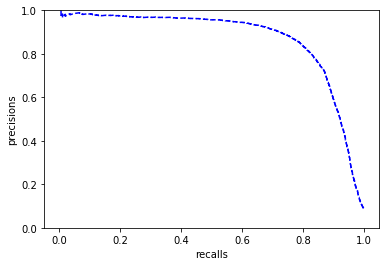

In [51]:
plot_presicion_vs_recall(precisions, recalls)
plt.show

<function matplotlib.pyplot.show>

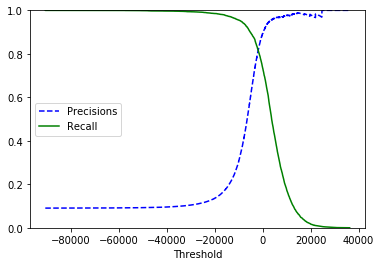

In [53]:
plot_presicion_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

In [65]:
y_train_pred_90 = (y_scores> 1000)

In [66]:
precision_score(y_train_5, y_train_pred_90)


0.9193190229459659

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.6873270614277809

In [69]:
from sklearn.metrics import roc_curve

In [71]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [78]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

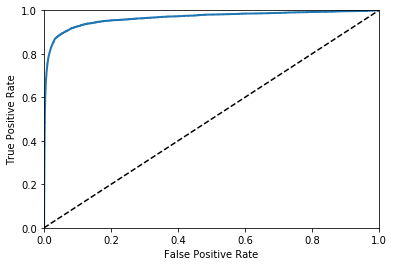

In [79]:
plot_roc_curve(fpr, tpr)
plt.show()

In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9653210656003651

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
forest_clf = RandomForestClassifier(random_state=42)

In [83]:
y_probas_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3,
                                   method = "predict_proba")

In [85]:
y_scores_forest = y_probas_forest[:,1]

In [87]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

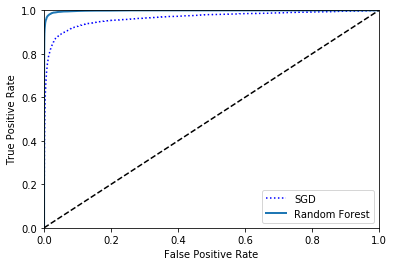

In [88]:
plt.plot(fpr, tpr, "b:", label ="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [90]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984450782101234

In [93]:
rm_precisions, rm_recalls, rm_thresholds = precision_recall_curve(y_train_5, y_scores_forest)
#precision_score(y_train_5, y_scores_forest)

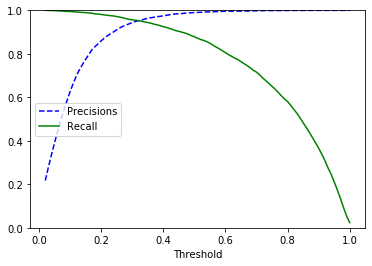

In [94]:
plot_presicion_recall_vs_threshold(rm_precisions, rm_recalls, rm_thresholds)

<function matplotlib.pyplot.show>

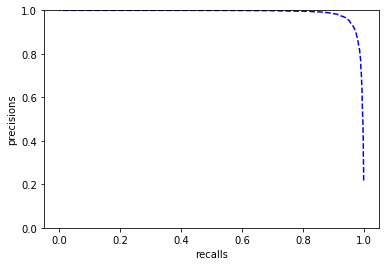

In [95]:
plot_presicion_vs_recall(rm_precisions, rm_recalls)
plt.show

In [96]:
y_fp_train_pred_90 = (y_scores_forest> 0.25)

In [97]:
precision_score(y_train_5, y_fp_train_pred_90)

0.919306844039909

In [98]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [99]:
sgd_clf.predict([some_digit])

array([5.])

In [100]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -1544.37425672, -18083.33136016,  -4315.61601303,
         -3712.58785603, -14216.52931799,    446.98748643,
        -35594.32806837,  -9094.18352315, -12377.50250002,
        -18895.90023756]])

In [101]:
np.argmax(some_digit_scores)

5

In [102]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [103]:
sgd_clf.classes_[5]

5.0

In [104]:
from sklearn.multiclass import OneVsOneClassifier

In [105]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [106]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [107]:
ovo_clf.predict([some_digit])

array([5.])

In [108]:
len(ovo_clf.estimators_)

45

In [109]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [110]:
forest_clf.predict([some_digit])

array([5.])

In [111]:
forest_clf.predict_proba([some_digit])

array([[0.02, 0.01, 0.  , 0.02, 0.02, 0.89, 0.01, 0.  , 0.01, 0.02]])

In [113]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring ="accuracy")

array([0.86085, 0.88045, 0.84615])

In [114]:
from sklearn.preprocessing import StandardScaler

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [118]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring ="accuracy")

/home/overlord/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

In [119]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/overlord/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5593,    0,   15,    6,    8,   38,   33,    4,  225,    1],
       [   0, 6425,   42,   19,    3,   42,    4,    8,  186,   13],
       [  20,   26, 5255,   92,   72,   22,   63,   35,  365,    8],
       [  28,   19,  103, 5251,    1,  202,   25,   43,  395,   64],
       [  12,   16,   37,    8, 5228,   10,   35,   16,  317,  163],
       [  24,   17,   22,  157,   56, 4482,   78,   16,  508,   61],
       [  29,   20,   40,    2,   43,   87, 5555,    7,  135,    0],
       [  22,   14,   52,   24,   48,   13,    4, 5710,  175,  203],
       [  15,   61,   41,   88,    3,  130,   30,   10, 5434,   39],
       [  23,   25,   27,   55,  125,   43,    1,  174,  351, 5125]])

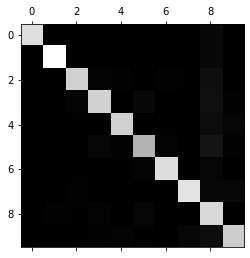

In [120]:
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()


In [121]:
row_sums = conf_mx.sum(axis =1, keepdims=True)
norm_conf_mx = conf_mx/ row_sums

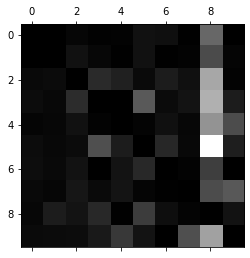

In [122]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

In [127]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [123]:
cl_a, cl_b = 3 ,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

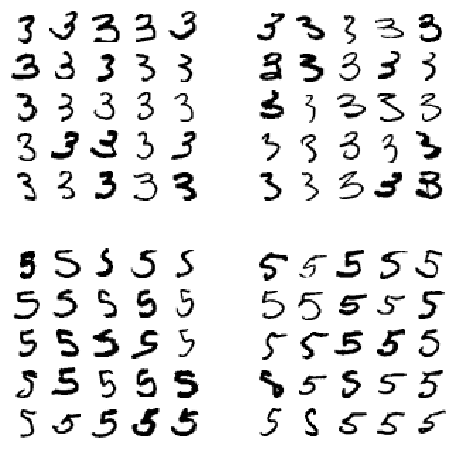

In [128]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [129]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [130]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [131]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [132]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv =3)

In [133]:
f1_score(y_multilabel,y_train_knn_pred, average ="macro")

0.9776081660940397

In [134]:
noise = np.random.randint(0,100, len(X_train), 784)
X_train_mod = X_train + noise
noise = np.random.randint(0,100, len(X_test), 784)
X_test_mod = X_test + noise
y_train_mod = X_Train
y_test_mod = X_test

TypeError: data type not understood

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)